<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/%D0%93%D0%B5%D0%B9%D0%BC%D1%81-%D0%A5%D0%B0%D1%83%D1%8D%D0%BB%D0%BB%20%D0%B4%D0%BB%D1%8F%20%D0%BA%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0%20%D1%83%D0%BD%D0%B8%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85%20%D0%BB%D0%B5%D0%BC%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import glob
import re
import pymorphy2
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy import stats

# Создаем экземпляр морфологического анализатора pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()

# Путь к папке с уровнями CEFR
cefr_levels = ["A1", "A2", "B1", "B2"]

# Список для хранения данных
data = []

# Список для хранения количества уникальных лемм во всех файлах
all_unique_lemma_counts = []

# Обработка каждого уровня CEFR
for cefr_level in cefr_levels:
    folder_path = f"/content/Students_texts/{cefr_level}"
    file_list = glob.glob(os.path.join(folder_path, "*.txt"))

    unique_lemma_counts = []

    # Обработка каждого файла в текущем уровне CEFR
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

            # Удаление тегов типа моя
            text = re.sub(r'<[^>]+>', '', text)

            # Удаление [unclear]
            text = text.replace('[unclear]', '')

            # Разделение текста на слова
            words = re.findall(r'\b\w+\b', text)

            # Список для хранения уникальных лемм с частями речи
            unique_lemmas = set()

            # Обработка каждого слова
            for word in words:
                # Пропускаем пустые слова
                if not word.strip():
                    continue

                # Приведение слова к лемме
                parsed_word = morph_analyzer.parse(word.lower())[0]
                lemma = parsed_word.normal_form
                pos = parsed_word.tag.POS

                # Формируем строку из леммы и части речи
                lemma_info = f"{lemma} {pos}"

                # Добавляем лемму в множество уникальных лемм
                unique_lemmas.add(lemma_info)

            # Количество уникальных лемм в файле
            unique_lemma_count = len(unique_lemmas)
            unique_lemma_counts.append(unique_lemma_count)
            all_unique_lemma_counts.append(unique_lemma_count)

    # Сохранение данных для анализа
    data.extend(list(zip([cefr_level] * len(file_list), unique_lemma_counts)))

# Вычисление статистик для количества уникальных лемм во всех файлах
mean_unique_lemma_count = np.mean(all_unique_lemma_counts)
sd_unique_lemma_count = np.std(all_unique_lemma_counts)
std_error_unique_lemma_count = stats.sem(all_unique_lemma_counts)
ci_unique_lemma_count = stats.t.interval(0.95, len(all_unique_lemma_counts)-1, loc=mean_unique_lemma_count, scale=std_error_unique_lemma_count)

# Вывод статистик для количества уникальных лемм во всех файлах
print("Статистики для количества уникальных лемм во всех файлах:")
print(f"Mean: {mean_unique_lemma_count}")
print(f"SD: {sd_unique_lemma_count}")
print(f"Std. Error: {std_error_unique_lemma_count}")
print(f"95% CI (confidence interval) (mean): {ci_unique_lemma_count}\n")

# Создаем DataFrame
df = pd.DataFrame(data, columns=['CEFR Level', 'Unique Lemma Count'])

# Проверка на наличие ненулевой вариабельности
if df['Unique Lemma Count'].nunique() <= 1:
    print("Ошибка: Недостаточная вариабельность в данных.")
else:
    # ANOVA
    anova_result = pg.anova(data=df, dv='Unique Lemma Count', between='CEFR Level')

    # Тест Геймса-Хауэлла
    games_howell_result = pg.pairwise_gameshowell(data=df, dv='Unique Lemma Count', between='CEFR Level')

    # Вывод результатов
    print(f"F-статистика (ANOVA): {anova_result['F'][0]}")
    print(f"p-value (ANOVA): {anova_result['p-unc'][0]}")

    print("\nGames-Howell Test Results:")
    print(games_howell_result)

Статистики для количества уникальных лемм во всех файлах:
Mean: 93.8158614402917
SD: 45.12830694277557
Std. Error: 1.3631503629358168
95% CI (confidence interval) (mean): (91.14118210465271, 96.49054077593068)

F-статистика (ANOVA): 163.66578520598352
p-value (ANOVA): 1.2829239322790464e-87

Games-Howell Test Results:
    A   B     mean(A)     mean(B)        diff        se          T  \
0  A1  A2   36.349206   75.618721  -39.269515  3.009095 -13.050273   
1  A1  B1   36.349206  106.066098  -69.716892  3.077848 -22.651179   
2  A1  B2   36.349206  139.842520 -103.493313  4.161779 -24.867568   
3  A2  B1   75.618721  106.066098  -30.447377  2.545689 -11.960366   
4  A2  B2   75.618721  139.842520  -64.223798  3.785206 -16.967054   
5  B1  B2  106.066098  139.842520  -33.776422  3.840089  -8.795740   

           df          pval    hedges  
0  135.235519  4.007905e-14 -1.127321  
1  146.958080  0.000000e+00 -1.813958  
2  187.725134  0.000000e+00 -3.126940  
3  904.167646  0.000000e+00 -

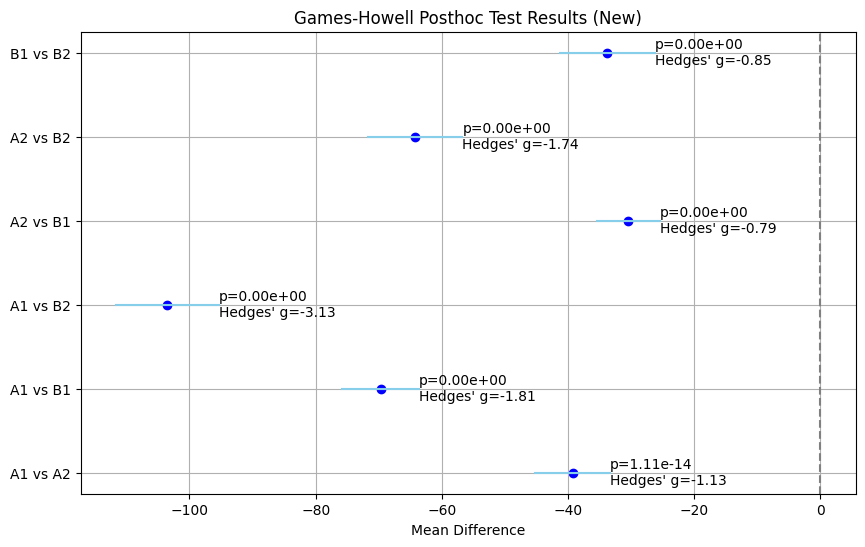

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Результаты теста Геймса-Хауэла для новых данных
games_howell_result_new = pd.DataFrame({
    'A': ['A1', 'A1', 'A1', 'A2', 'A2', 'B1'],
    'B': ['A2', 'B1', 'B2', 'B1', 'B2', 'B2'],
    'mean(A)': [36.349206, 36.349206, 36.349206, 75.618721, 75.618721, 106.066098],
    'mean(B)': [75.618721, 106.066098, 139.842520, 106.066098, 139.842520, 139.842520],
    'diff': [-39.269515, -69.716892, -103.493313, -30.447377, -64.223798, -33.776422],
    'se': [3.009095, 3.077848, 4.161779, 2.545689, 3.785206, 3.840089],
    'T': [-13.050273, -22.651179, -24.867568, -11.960366, -16.967054, -8.795740],
    'df': [135.235519, 146.958080, 187.725134, 904.167646, 198.562935, 209.439994],
    'pval': [1.110223e-14, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
    'hedges': [-1.127321, -1.813958, -3.126940, -0.791408, -1.744616, -0.848940]
})

# Расчет доверительных интервалов
z_score = 1.96
conf_intervals_new = [
    (md - z_score * s, md + z_score * s) for md, s in zip(games_howell_result_new['diff'], games_howell_result_new['se'])
]

# Построение графика
plt.figure(figsize=(10, 6))
for i, (group, ci, p, h) in enumerate(
    zip(games_howell_result_new['A'] + ' vs ' + games_howell_result_new['B'], conf_intervals_new, games_howell_result_new['pval'], games_howell_result_new['hedges'])
):
    plt.plot(ci, [i, i], color="skyblue")
    plt.scatter(games_howell_result_new['diff'].iloc[i], i, color="blue")
    plt.text(ci[1] + 0.05, i, f"p={p:.2e}\nHedges' g={h:.2f}", va='center')

# Элементы оформления
plt.yticks(range(len(games_howell_result_new)), games_howell_result_new['A'] + ' vs ' + games_howell_result_new['B'])
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel("Mean Difference")
plt.title("Games-Howell Posthoc Test Results (New)")
plt.grid(True)
plt.show()